<h1 align='center'>Capuchinbird Audio Classification</h1>

## STEP 1 : Imports

In [1]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 15.3 MB/s eta 0:00:00


In [35]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import IPython.display as ipd
import librosa
import librosa.display
import wave
from scipy.io import wavfile

from google.colab import drive
from google.colab import files

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 2 : Get the data

In [ ]:
! pip install -q kaggle

In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
### Mount to g-drive (Sign in required for the mount)
drive.mount("/content/gdrive", force_remount=True)
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"krishnendudey","key":"881649db0f6b090beb7c4ba1a96a4ed9"}'}

In [ ]:
## create a kaggle folder and move the kaggle.json file into that
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
## Change permissions to the directory and file
! chmod 600 ~/.kaggle/kaggle.json
! chmod 777 "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio"

In [ ]:
## Move to the directory where the file is to be downloaded
%cd "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio"

/content/gdrive/MyDrive/Python_DA_DS_ML/Audio


In [ ]:
%%time
## download the dataset in the directory where you are
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

In [ ]:
## Unzip the data to a specifi folder named "Data"
!unzip -q "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio/z-by-hp-unlocked-challenge-3-signal-processing.zip" -d "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Data"

## STEP 2 : Auralize & Visualize

In [4]:
main_dir="/content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Data"
capuchinbird_audio_dir = os.path.join(main_dir,'Parsed_Capuchinbird_Clips')
non_capuchinbird_audio_dir = os.path.join(main_dir,'Parsed_Not_Capuchinbird_Clips')

capuchin_audio_sample = os.path.join( capuchinbird_audio_dir, os.listdir(capuchinbird_audio_dir)[0])
non_capuchin_audio_sample = os.path.join( non_capuchinbird_audio_dir, os.listdir(non_capuchinbird_audio_dir)[0])

***Capuchin Bird audio sample***

In [5]:
ipd.Audio(capuchin_audio_sample, rate=16000)

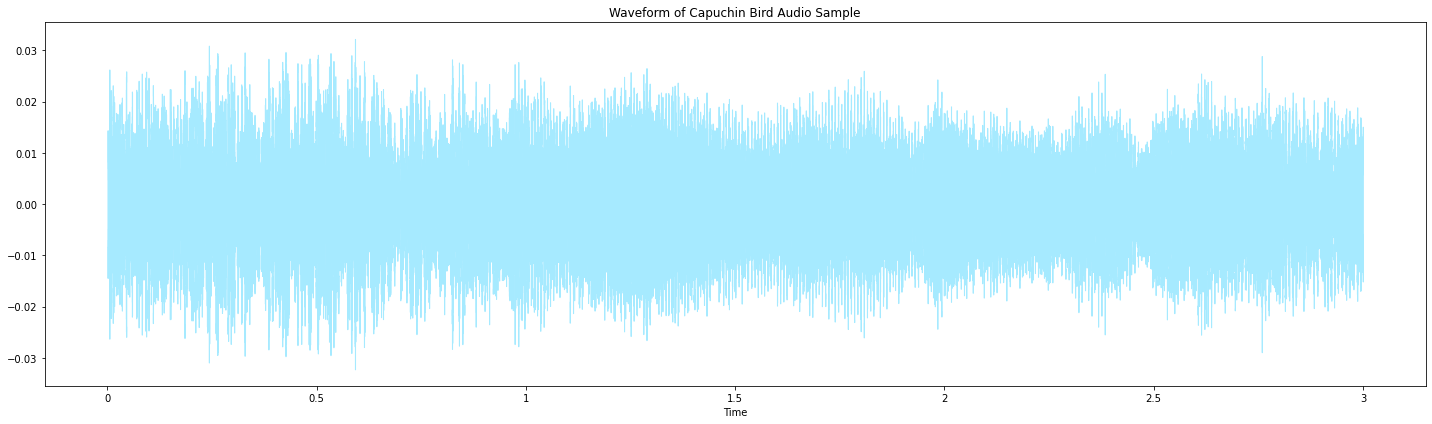

In [6]:
data, sr = librosa.load(capuchin_audio_sample)
plt.figure(figsize=(20,6))
plt.title("Waveform of Capuchin Bird Audio Sample")
# plt.plot(data, color='#A6EAFF')
librosa.display.waveshow(data, sr=sr,color='#A6EAFF')
plt.tight_layout()

***Non-Capuchin Bird audio sample***

In [7]:
ipd.Audio(non_capuchin_audio_sample, rate=16000)

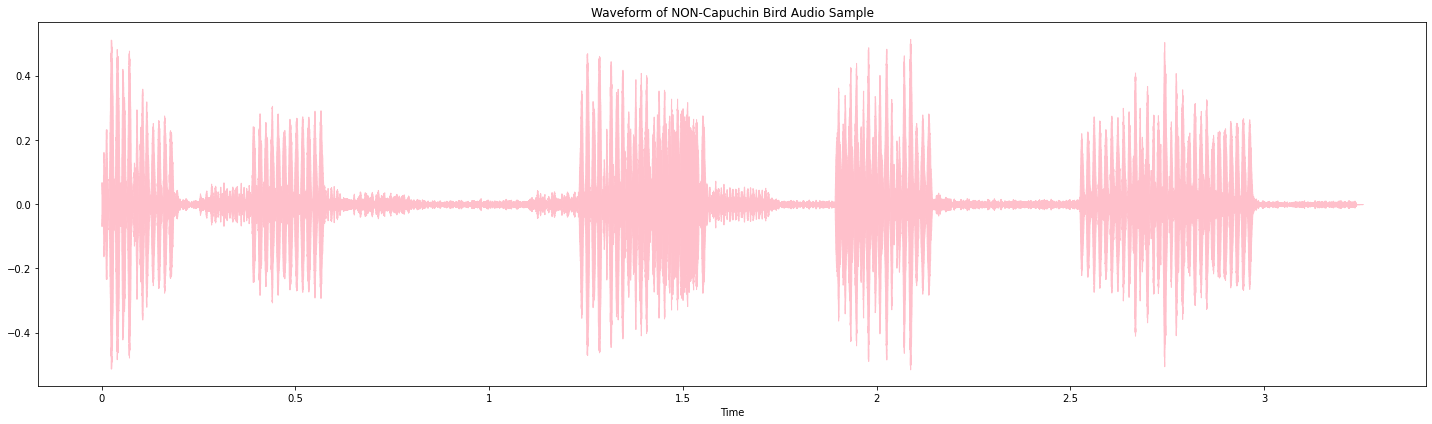

In [8]:
data_, sr = librosa.load(non_capuchin_audio_sample)
plt.figure(figsize=(20,6))
plt.title("Waveform of NON-Capuchin Bird Audio Sample")
# plt.plot(data_, color='pink')
librosa.display.waveshow(data_, sr=sr,color='pink')
plt.tight_layout()

**Note :** 
1. While reading with librosa we will always get sample rate = 22.5 kHz
2. Librosa converts the audio into mono channel by default
3. Librosa standardizes the audio data by default

**Actual Reading of Data**

In [9]:
actual_sr,actual_data= wavfile.read(capuchin_audio_sample)

print("Number of Channels : ", actual_data.shape[1])
print("Sample Rate of the audio clip : {} kHz".format(sr/1000))
print("Duration of the clip : {} sec".format(actual_data.shape[0]/actual_sr))

Number of Channels :  2
Sample Rate of the audio clip : 22.05 kHz
Duration of the clip : 3.0 sec


In [10]:
channel1_data=[actual_data[i][0] for i in range(actual_data.shape[0])]
channel2_data=[actual_data[i][1] for i in range(actual_data.shape[0])]

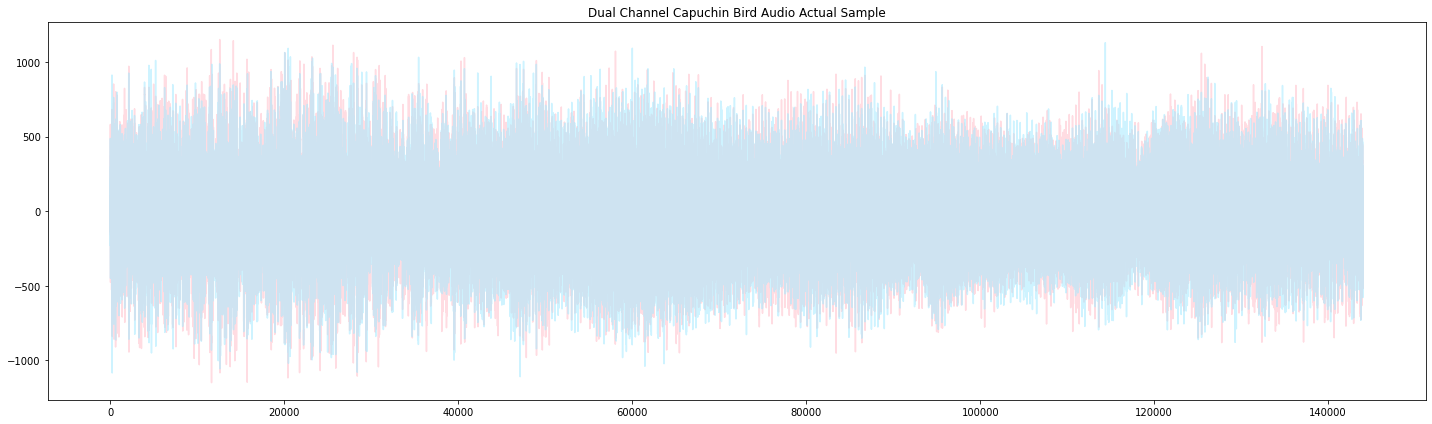

In [11]:
plt.figure(figsize=(20,6))
plt.title("Dual Channel Capuchin Bird Audio Actual Sample")
plt.plot(channel1_data,alpha=0.55, color='pink')
plt.plot(channel2_data,alpha=0.55, color='#A6EAFF')
plt.tight_layout()

In [12]:
# d=pd.DataFrame(data=channel1_data, columns=['channel_1'])
# d['normalised_channel_1']=[(d.loc[i].channel_1-d.channel_1.min())/d.channel_1.std() for i in range(d.shape[0])]

## STEP3 : Loading Dataset

The audio clips are 1 second or less at 16kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

**STEP 3.1 :** Define Paths to Capuchin and Non-Capuchin Data

In [13]:
Capuchin = os.path.join(main_dir, 'Parsed_Capuchinbird_Clips')
Non_Capuchin = os.path.join(main_dir, 'Parsed_Not_Capuchinbird_Clips')

**STEP 3.2 :** Create Tensorflow Dataset

In [14]:
Capuchin_ds = tf.data.Dataset.list_files(Capuchin+'/*.wav')
Non_Capuchin_ds = tf.data.Dataset.list_files(Non_Capuchin+'/*.wav')

**STEP 3.2 :** Add labels and Combine Capuchin and Non-Capuchin Samples

In [15]:
Capuchin_ds_with_labels  = tf.data.Dataset.zip((Capuchin_ds , 
                                                tf.data.Dataset.from_tensor_slices(tf.ones(len(Capuchin_ds)))))
Non_Capuchin_ds_with_labels  = tf.data.Dataset.zip((Non_Capuchin_ds , 
                                                    tf.data.Dataset.from_tensor_slices(tf.zeros(len(Non_Capuchin_ds)))))
data_ds = Capuchin_ds_with_labels.concatenate(Non_Capuchin_ds_with_labels )

In [16]:
data_ds

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

The below function converts a Sterio audio into Mono with the use of tf.audio.decode_wav. This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis.

In [17]:
def load_wav_16k_mono(file,label):
    audio_binary = tf.io.read_file(file)
    audio, sample_rate = tf.audio.decode_wav(audio_binary,desired_channels=1)
    waveform=tf.squeeze(audio, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    waveform = tfio.audio.resample(waveform, rate_in=sample_rate , rate_out=16000)
    return waveform, label

In [18]:
ds = data_ds.map(load_wav_16k_mono, num_parallel_calls=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
def padding(file, label):
    wav = file[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav , label

In [20]:
ds = ds.map(padding, num_parallel_calls=tf.data.AUTOTUNE)

## STEP 4 : Spectogram Creation

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.
<br><br>
A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on

In [21]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=320, frame_step=32)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

***Spectrogram Capuchin Bird audio sample***

Waveform shape: (66150,)
Spectrogram shape: (2058, 257, 1)


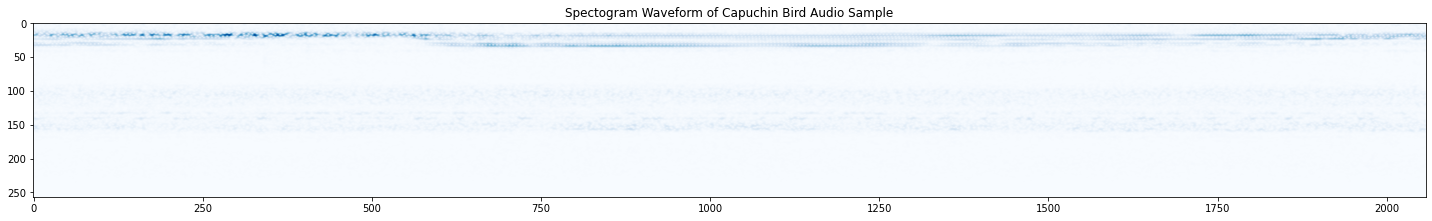

In [22]:
spectogram_capuchin_audio_sample=get_spectrogram(data)
plt.figure(figsize=(20,6))
plt.imshow(tf.transpose(spectogram_capuchin_audio_sample)[0],cmap='Blues')
plt.title("Spectogram Waveform of Capuchin Bird Audio Sample")
plt.tight_layout()
print('Waveform shape:', data.shape)
print('Spectrogram shape:', spectogram_capuchin_audio_sample.shape)

***Spectrogram Non-Capuchin Bird audio sample***

Waveform shape: (71751,)
Spectrogram shape: (2233, 257, 1)


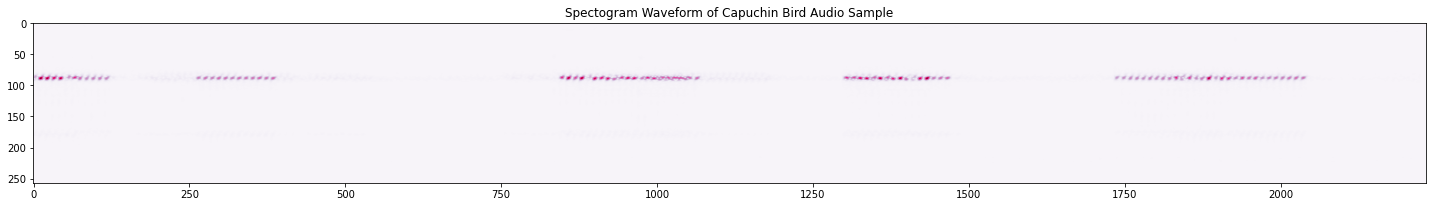

In [23]:
spectogram_non_capuchin_audio_sample=get_spectrogram(data_)
plt.figure(figsize=(20,6))
plt.imshow(tf.transpose(spectogram_non_capuchin_audio_sample)[0],cmap='PuRd')
plt.title("Spectogram Waveform of Capuchin Bird Audio Sample")
plt.tight_layout()
print('Waveform shape:', data_.shape)
print('Spectrogram shape:', spectogram_non_capuchin_audio_sample.shape)

Now, create spectrogramn datasets from the audio datasets

In [24]:
def make_spec_ds(ds):
    return ds.map( map_func=lambda audio,label: 
                  (get_spectrogram(audio), label),num_parallel_calls=tf.data.AUTOTUNE)

def preprocess(ds,buffer_size,batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [25]:
spectrogram_ds = make_spec_ds(ds)
spectrogram_ds = preprocess(ds = spectrogram_ds,buffer_size = 1000 ,batch_size =16)

## STEP 5 : Splitting

In [26]:
print("Total number of train+val samples : ", len(ds))
print("Total number of samples in one batch  : ",len(spectrogram_ds))  # 810/batch_size = 810/16 = 51(approx)

Total number of train+val samples :  810
Total number of samples in one batch  :  51


In [27]:
train_ds = spectrogram_ds.take(36)
test_ds = spectrogram_ds.skip(36).take(15)

In [28]:
print("Train : ", len(train_ds))
print("Validation : ", len(test_ds))

Train :  36
Validation :  15


## STEP 6 : Modeling

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [31]:
samples, label = spectrogram_ds.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [29]:
input_shape = (1491, 257, 1)
model = Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                        

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'],run_eagerly=True)

In [34]:
GPU_name=tf.config.list_physical_devices('GPU')[0].name[17:]
print("GPU Name : ", GPU_name)

GPU Name :  GPU:0


In [39]:
%%time
EPOCHS=80
batch_size=64
filepath= "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Model-weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
callback = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only=True, mode= 'max')
with tf.device(device_name=GPU_name):
  history = model.fit(
              train_ds,
              validation_data=test_ds,  
              epochs=EPOCHS,batch_size=batch_size,callbacks=[callback], verbose=1, use_multiprocessing=True)


Epoch 1/80


35/36 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8696
Epoch 1: val_accuracy improved from -inf to 0.90171, saving model to /content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Model-weights-improvement-01-0.9017.hdf5
36/36 [==============================] - 219s 62ms/step - loss: 0.3220 - accuracy: 0.8715 - val_loss: 0.2619 - val_accuracy: 0.9017
Epoch 2/80
35/36 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9482
Epoch 2: val_accuracy improved from 0.90171 to 0.97009, saving model to /content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Model-weights-improvement-02-0.9701.hdf5
36/36 [==============================] - 2s 59ms/step - loss: 0.1462 - accuracy: 0.9479 - val_loss: 0.1081 - val_accuracy: 0.9701
Epoch 3/80
35/36 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9732
Epoch 3: val_accuracy improved from 0.97009 to 0.98718, saving model to /content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Model-weights-improvement-03-0.987

## STEP 8 : Performance curves

In [40]:
# Plot Utility
def plot_graphs(history, string):
    #plt.ylim([0,1])
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

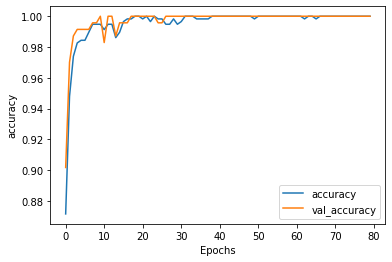

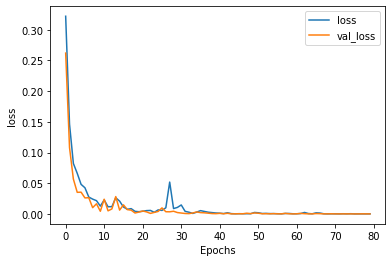

In [41]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## STEP 9 : Prediction on Test Data

In [42]:
x_test, y_test  = test_ds.as_numpy_iterator().next()

In [43]:
x_test.shape

(16, 1491, 257, 1)

In [44]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 57ms/step
[[0.0000000e+00]
 [9.9757391e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [3.4532954e-10]
 [4.0810452e-11]
 [9.9999952e-01]
 [1.0000000e+00]
 [7.8458197e-06]
 [6.6153585e-09]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [9.9999857e-01]
 [1.0000000e+00]
 [1.3346005e-10]]


In [45]:
y_pred = [1 if i>0.5 else 0 for i in y_pred]

In [46]:
pred_df=pd.DataFrame()
pred_df['y_test']=y_test
pred_df['y_pred']=y_pred
pred_df

y_test  y_pred
0      0.0       0
1      1.0       1
2      1.0       1
3      1.0       1
4      0.0       0
5      0.0       0
6      1.0       1
7      1.0       1
8      0.0       0
9      0.0       0
10     1.0       1
11     0.0       0
12     1.0       1
13     1.0       1
14     1.0       1
15     0.0       0

## STEP 10 : Load up test mp3 clip

In [48]:
def load_mp3_16k_mono(file):
    audio_binary = tfio.audio.AudioIOTensor(file)
    tensor = audio_binary.to_tensor()
    tensor= tf.math.reduce_sum(tensor, axis=1) / 2      ## taking the average of the two audio channels
    sample_rate = audio_binary.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    waveform = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return waveform

In [58]:
sample_mp3_filepath = "/content/gdrive/MyDrive/Python_DA_DS_ML/Audio/Data/Forest Recordings/recording_00.mp3"
sample_mp3_to_wav = load_mp3_16k_mono(sample_mp3_filepath)
mp3_audio = ipd.Audio(sample_mp3_to_wav, rate=16000)
mp3_audio

## STEP 11 : Create audio slices from the longer clips

When sequence_length == sequence_stride , there is no overlap between the waveforms of two consecutive windows.

In [56]:
def create_timeseries_audio_slices(file):
    return tf.keras.utils.timeseries_dataset_from_array(data=file, 
                                                        targets=file, 
                                                        batch_size=1,
                                                        sequence_length = 48000,
                                                        sequence_stride=48000)

In [63]:
mp3_audio_slices = create_timeseries_audio_slices(file = sample_mp3_to_wav)
samples, index = mp3_audio_slices.as_numpy_iterator().next()
print("Number of windows created from the audio sample : ", len(mp3_audio_slices))

Number of windows created from the audio sample :  60


## STEP 12 : Convert Clips into Windowed Spectrograms & Predictions

In [64]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [66]:
mp3_audio_slices = create_timeseries_audio_slices(file = sample_mp3_to_wav)
mp3_audio_slices= mp3_audio_slices.map(preprocess_mp3)
mp3_audio_slices = mp3_audio_slices.batch(64)
mp3_audio_slices

<BatchDataset element_spec=TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None)>

In [69]:
### Predictions 
y_preds = model.predict(mp3_audio_slices)
y_preds =  [1 if i>0.5 else 0 for i in y_preds]
len(y_preds)

1/1 [==============================] - 1s 1s/step


60

**References :** <br>
- DATA : https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
- Tutorial : 
    - https://www.youtube.com/watch?v=ZLIPkmmDJAc&list=LL&index=1&ab_channel=NicholasRenotte
- Useful materials:
    - https://www.tensorflow.org/io/tutorials/audio
    - https://www.tensorflow.org/tutorials/audio/simple_audio